# The Problem: Discrimination by Proxy

In [1]:
import json
from DiscriminationMitigation import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # turn off tensorflow warning messages

### Instantiate some synthetic data

In [2]:
def simple_synth(n=8000, class_prob=0.5, gamma=np.matrix([[2,3.5],[.4,.6]]), alpha=np.matrix([[0,2]]), 
                 beta=np.matrix([[2,2],[1,1]])):
    
    np.random.seed(1776)

    # Protected class variable
    c1 = np.random.binomial(1, p=class_prob, size=n) # group 1
    c0 = 1-c1 # group 0

    # Other covariates
    w0 = gamma[0,0]*c0 + gamma[0,1]*c1 + np.random.normal(0, 0.5, size=n) # linear function of class & shock
    w1 = gamma[1,0]*c0 + gamma[1,1]*c1 + np.random.normal(0, 0.3, size=n)
                                                                 
    # Outcome variable
    y = alpha[0,0]*c0   + alpha[0,1]*c1 + beta[0,0]*c0*w0 + beta[0,1]*c1*w0 + beta[1,0]*c0*w1 + beta[1,1]*c1*w1 + \
        np.random.normal(0, 0.3, size=n)

    return pd.DataFrame([y, c0, c1, w0, w1]).T.rename(columns={0:'y', 1: 'c0', 2: 'c1', 3: 'w0', 4:'w1'})

In [3]:
synth = simple_synth()
print(synth.head())
print("\n", synth.shape)

          y   c0   c1        w0        w1
0  4.673528  1.0  0.0  2.214135  0.324108
1  7.939870  0.0  1.0  2.404301  1.070192
2  5.222822  1.0  0.0  2.338783  0.519127
3  9.406248  0.0  1.0  3.145858  0.822292
4  3.990423  1.0  0.0  1.523643  0.897265

 (8000, 5)


In these synthetic data, we have a target variable *y* that we are trying to predict, we have dummies for two categories of a protected class *c1* and *c0*, and we have covariates *w1* and *w2*.  Class membership is drawn from a binomial distribution. Covariates depend upon independent normal draws plus class category-specific means.  These means generate correlation between class category membership and covariates.  The target variables *y* is determined by covariates, independent normal draws, and class category membership. Class category membership causing y can be though of many ways. We find it most convenient to interpret it as representing unobserved causal variables that are correlated with protected class, but it could also represent bias in the target or taste-based discrimination in the target. 

### Visualizing the problem

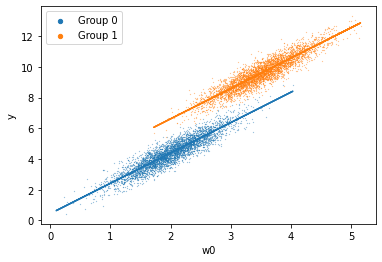

In [4]:
c0_grp = synth.loc[synth["c0"] == 1]
c1_grp = synth.loc[synth["c1"] == 1]

# Estimate fitted values from a linear regression model
c0_pred = LinearRegression().fit(c0_grp[["w0"]], c0_grp["y"]).predict(c0_grp[["w0"]])
c1_pred = LinearRegression().fit(c1_grp[["w0"]], c1_grp["y"]).predict(c1_grp[["w0"]])

# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

*Cullen - I think we need an explanation here. You can potentially use some of the text from above, and shorten that block*

### The naive approach: Exclude all protected class features from the model

In [5]:
# Train a Tensorflow Keras deep learning model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(synth[['w0']], synth['y'], epochs=60, batch_size=128, verbose=0)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  64        
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  4224      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2064      
_________________________________________________________________
dense_3 (Dense)              multiple                  17        
Total params: 6,369
Trainable params: 6,369
Non-trainable params: 0
______________________________________________________

In [6]:
# Generate prediction from model
pred = model.predict(synth[['w0']])

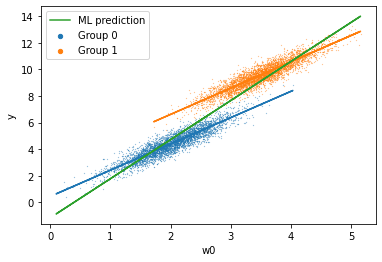

In [7]:
# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.plot(synth['w0'], pred, label='ML prediction')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

*Cullen - we need to explain the above*

# How to use `DiscriminationMitigator`

*We need an introduction*

### Example configuration file

In [8]:
with open('example_config.json') as j:
    config = json.load(j)

print("Example configuration dictionary: \n", config)

Example configuration dictionary: 
 {'protected_class_features': ['c0', 'c1'], 'target_feature': ['y']}


### Train a Tensorflow Keras Sequential deep learning model
#### *Note the inclusion of the protected class feature(s) in the model!*

In [10]:
# Train a Tensorflow Keras deep learning model
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(synth[['c0', 'c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)

In [11]:
# Create Pandas dataframe of mitigated estimates
mitigated = DiscriminationMitigator(df=synth[['c0', 'c1', 'w0']], model=model, 
                              config=config).predictions()

In [12]:
# Concatenate w0 and round w0
mitigated = pd.concat([mitigated, synth[['w0']].reset_index(drop=True)], axis=1)
mitigated['w0'] = round(mitigated['w0'], 1)

In [13]:
mitigated = mitigated.sort_values(by=['w0']).reset_index(drop=True)
agg = mitigated.groupby(['w0']).mean()
print(agg)

     unadj_pred   unif_wts
w0                        
0.1    0.782636   1.853770
0.2    1.043848   2.114982
0.3    1.101079   2.172213
0.4    1.342556   2.413691
0.5    1.535683   2.606817
..          ...        ...
4.8   11.979044  10.907909
4.9   12.176043  11.104908
5.0   12.365775  11.294641
5.1   12.557953  11.486818
5.2   12.678317  11.607183

[52 rows x 2 columns]


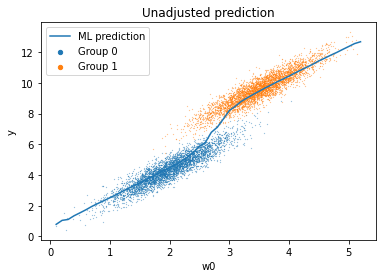

In [14]:
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(agg['unadj_pred'], label='ML prediction')
plt.title('Unadjusted prediction')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

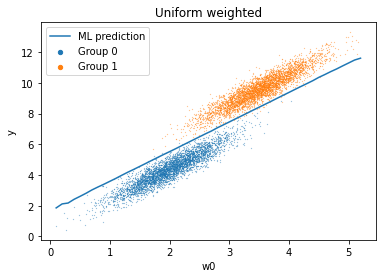

In [15]:
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
#plt.plot(c0_grp["w0"], c0_pred)
#plt.plot(c1_grp["w0"], c1_pred)
plt.plot(agg['unif_wts'], label='ML prediction')
plt.title('Uniform weighted')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

#### Example 1: The simplest case

In [15]:
ex1 = DiscriminationMitigator(df=synth[['c0', 'c1', 'w0']], model=model, 
                              config=config, ).predictions()

In [56]:
print(ex1.head())

   unadj_pred  unif_wts   pop_wts
0    4.833887  4.833887  4.833887
1    7.396267  5.193788  5.193788
2    5.069790  5.069790  5.069790
3    8.799704  6.597224  6.597224
4    3.527092  3.527092  3.527092


In the following examples, unadjusted predictions (`unadj_pred`) and uniform weights (`unif_wts`) remain the same. Population weights (`pop_wts`) in this case pertain to the marginal distributions per protected class feature in `df`. 

In [16]:
print("Dataframe of predictions: \n", ex1.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex1.describe())
print("\nCorrelation matrix of predictions: \n", ex1.corr())

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts
0    4.861357  4.861357  4.861357
1    7.425452  5.234289  5.234289
2    5.105803  5.105803  5.105803
3    8.879708  6.688545  6.688545
4    3.507243  3.507243  3.507243

Statistical moments: 
         unadj_pred     unif_wts      pop_wts
count  8000.000000  8000.000000  8000.000000
mean      7.002795     5.911870     5.911870
std       2.747165     1.765488     1.765488
min       0.717841     0.717841     0.717841
25%       4.423936     4.421038     4.421038
50%       6.883544     5.889902     5.889902
75%       9.579529     7.392834     7.392834
max      12.819020    10.627858    10.627858

Correlation matrix of predictions: 
             unadj_pred  unif_wts   pop_wts
unadj_pred    1.000000  0.975594  0.975594
unif_wts      0.975594  1.000000  1.000000
pop_wts       0.975594  1.000000  1.000000


#### Example 2: Use the marginals from another dataset (`train`)

In [12]:
ex2 = DiscriminationMitigator(df=X_test, model=model, config=config, train=X_train, weights=None).predictions()

In cases that the training set (or another dataset) is considerably larger and potentially more population representative than `df`, you may want to reweight the adjusted predictions in `pop_wts` to the marginals of all protected class features in this other dataset.

In [13]:
print("Dataframe of predictions: \n", ex2.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex2.describe())
print("\nCorrelation matrix of predictions: \n", ex2.corr())

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts
0    6.746980  6.758377  6.767430
1    6.075054  6.103145  6.106634
2    5.917782  5.889691  5.885582
3    6.499167  6.521694  6.527037
4    6.741848  6.753245  6.762299

Statistical moments: 
        unadj_pred    unif_wts     pop_wts
count  500.000000  500.000000  500.000000
mean     6.191450    6.191427    6.191072
std      0.549065    0.565770    0.571420
min      4.960387    4.943426    4.935606
25%      5.721015    5.703740    5.695550
50%      6.198308    6.196548    6.197703
75%      6.657816    6.679993    6.684631
max      7.633538    7.650499    7.657698

Correlation matrix of predictions: 
             unadj_pred  unif_wts   pop_wts
unadj_pred    1.000000  0.999761  0.999663
unif_wts      0.999761  1.000000  0.999976
pop_wts       0.999663  0.999976  1.000000


In [14]:
compare_pop = pd.concat([ex1['pop_wts'].rename('df'), ex2['pop_wts'].rename('train')], axis=1)
print("Compare population weights from 'df' vs. 'train':")
print(compare_pop.describe())

Compare population weights from 'df' vs. 'train':
               df       train
count  500.000000  500.000000
mean     6.191450    6.191072
std      0.571420    0.571420
min      4.935985    4.935606
25%      5.695928    5.695550
50%      6.198081    6.197703
75%      6.685009    6.684631
max      7.658076    7.657698


#### Example 3: Use the marginals from another dataset and use custom weights

In [15]:
ex3 = DiscriminationMitigator(df=X_test, model=model, config=config, train=X_train, weights=weights).predictions()


Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


You may also want to reweight predictions to ask 'what-if' questions: i.e. what if the share of group *x* were different than their observed share in the data? Providing a dictionary of marginal distributions to `weights` will allow for this.

In [18]:
print("Custom weights:", weights, "\n")
print("Dataframe of predictions: \n", ex3.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex3.describe())
print("\nCorrelation matrix of predictions: \n", ex3.corr())

Custom weights: {'z': {'1': 0.9, '2': 0.02, '3': 0.04, '4': 0.04}} 

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts  cust_wts
0    6.746980  6.758377  6.767430  6.744531
1    6.075054  6.103145  6.106634  6.105993
2    5.917782  5.889691  5.885582  5.915334
3    6.499167  6.521694  6.527037  6.518977
4    6.741848  6.753245  6.762299  6.739400

Statistical moments: 
        unadj_pred    unif_wts     pop_wts    cust_wts
count  500.000000  500.000000  500.000000  500.000000
mean     6.191450    6.191427    6.191072    6.205807
std      0.549065    0.565770    0.571420    0.548989
min      4.960387    4.943426    4.935606    4.980197
25%      5.721015    5.703740    5.695550    5.741638
50%      6.198308    6.196548    6.197703    6.206755
75%      6.657816    6.679993    6.684631    6.681364
max      7.633538    7.650499    7.657698    7.642218

Correlation matrix of predictions: 
             unadj_pred  unif_wts   pop_wts  cust_wts
unadj_pred    1.000000  0.999761  0.99

#### Example 4: Reweighting multiple features at onece - possible, but to be avoided!

In [19]:
new_weights = {'c0': {0.0: 0.1, 1.0: 0.9}, 'c1': {0.0: 0.9, 1.0: 0.1}, 'z': {1.0: 0.9, 2.0: 0.02, 3.0: 0.04, 4.0: 0.04}}
ex4 = DiscriminationMitigator(df=X_test, model=model, config=config, train=X_train, weights=new_weights).predictions()


Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


JOE: I don't understand what you are getting at here.  

Though `DiscriminationMitigator` does not forbid it, we discourage users from reweighting multiple protected class features at the same time. The reason being that this attenuates the effect of the individual reweighted protected class feature. Each reweighted feature produces an *N* x 1 vector, so the preceding creates 3 counterfactual vectors, which are then averaged across for each person. Though the marginals may be weighted differently, this averaging may produce very similar predictions between `pop_wts` and `cust_wts` and should be hence avoided.

In [17]:
print("Custom weights:", new_weights, "\n")
print("Dataframe of predictions: \n", ex4.reset_index(drop=True).head())
print("\nStatistical moments: \n", ex4.describe())
print("\nCorrelation matrix of predictions: \n", ex4.corr())

Custom weights: {'c0': {0.0: 0.1, 1.0: 0.9}, 'c1': {0.0: 0.9, 1.0: 0.1}, 'z': {1.0: 0.9, 2.0: 0.02, 3.0: 0.04, 4.0: 0.04}} 

Dataframe of predictions: 
    unadj_pred  unif_wts   pop_wts  cust_wts
0    6.661998  6.676531  6.654327  6.601067
1    6.271629  6.202929  6.208470  6.155210
2    5.450657  5.519357  5.515208  5.461948
3    6.695879  6.654924  6.651216  6.597956
4    6.580443  6.594976  6.572772  6.519513

Statistical moments: 
        unadj_pred    unif_wts     pop_wts    cust_wts
count  500.000000  500.000000  500.000000  500.000000
mean     6.141468    6.141298    6.142123    6.088863
std      0.559403    0.533642    0.526824    0.526824
min      4.807796    4.876495    4.872347    4.819087
25%      5.643587    5.679643    5.691246    5.637986
50%      6.155550    6.154496    6.149170    6.095911
75%      6.611161    6.593558    6.573488    6.520228
max      7.422514    7.353815    7.359354    7.306095

Correlation matrix of predictions: 
             unadj_pred  unif_wts   